In [1]:
import pandas as pd
import numpy as np
import nannyml as nml
import nannyml_premium as nml_premium
from nannyml_premium.performance_estimation.confidence_based import MCBPE
from nannyml_premium.concept_shift.rcs import ClassificationConceptShiftEstimator

In [2]:
df_raw = pd.read_csv('data/energy_data.csv', index_col=0)
df_raw.head()

/var/folders/yn/9gj_99ys1mz0_tkl2kvh5wd40000gn/T/ipykernel_36045/1183489363.py:1: DtypeWarning: Columns (9,10,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('data/energy_data.csv', index_col=0)


,name,unit,year,month,day,hour,consumption,temp_outside,purpose_of_use,gross_area,floor_area,apartment_sector,total_volume,building_type,ids
time,,,,,,,,,,,,,,,
2020-01-08 14:00:00.000,Heat,MWh,2020,1,8,14,0.131,5.7,General educational institutions' rak.,5164.5000000000,4610,4433.2,22630.0,NaN,25
2020-12-05 19:00:00.000,Heat,MWh,2020,12,5,19,0.052,3.6,General educational institutions' rak.,5164.5000000000,4610,4433.2,22630.0,NaN,25
2021-06-30 20:00:00.000,Heat,MWh,2021,6,30,20,0.008,14.5,General educational institutions' rak.,5164.5000000000,4610,4433.2,22630.0,NaN,25
2019-10-31 00:00:00.000,Heat,MWh,2019,10,31,0,0.096,3.9,General educational institutions' rak.,5164.5000000000,4610,4433.2,22630.0,NaN,25
2020-06-29 21:00:00.000,Heat,MWh,2020,6,29,21,0.009,14.9,General educational institutions' rak.,5164.5000000000,4610,4433.2,22630.0,NaN,25


In [3]:
df_building_1 = df_raw[df_raw['ids'] == 1]
df_building_1 = df_building_1.sort_values(by='time')
df_building_1['time'] = df_building_1.index.astype('datetime64[ns]')

The data drift analysis encompasses the input variables co2 and room temperature, alongside the target variable measured

Consequently, the dataset is divided into two parts: training
data, which includes records from March 30, 2021, at 12:12
AM to May 8, 2021, at 11:57 PM, and test data, which spans
from May 9, 2021, at 12:00 AM to July 11, 2021, at 11:57 PM.

In [4]:
df_train = df_building_1[(df_building_1['time'] >= '2019-04-01 00:00:00') & (df_building_1['time'] <= '2020-03-31 23:00:00')]
df_test = df_building_1[(df_building_1['time'] >= '2020-04-01 00:00:00') & (df_building_1['time'] <= '2021-03-31 23:00:00')]
df_prod = df_building_1[(df_building_1['time'] >= '2021-04-01 00:00:00') & (df_building_1['time'] <= '2022-03-31 23:00:00')]

print(f'train set')
print(f'lenght: {len(df_train)}')
print(f'from: {df_train.time.iloc[0]} to {df_train.time.iloc[-1]}')
print('\n')

print(f'test set')
print(f'lenght: {len(df_test)}')
print(f'from: {df_test.time.iloc[0]} to {df_test.time.iloc[-1]}')
print('\n')

print(f'prod set')
print(f'lenght: {len(df_prod)}')
print(f'from: {df_prod.time.iloc[0]} to {df_prod.time.iloc[-1]}')

train set
lenght: 35136
from: 2019-04-01 00:00:00 to 2020-03-31 23:00:00


test set
lenght: 35040
from: 2020-04-01 00:00:00 to 2021-03-31 23:00:00


prod set
lenght: 35040
from: 2021-04-01 00:00:00 to 2022-03-31 23:00:00


## Bulding a model

In [5]:
model_features = ['month', 'day', 'hour', 'temp_outside']
target = 'consumption'

X_train = df_train[model_features]
y_train = df_train[target].values

X_test = df_test[model_features]
y_test = df_test[target].values

from lightgbm import LGBMRegressor

reg = LGBMRegressor()
reg.fit(X_train, y_train)

LGBMRegressor()

In [6]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

y_train_preds = reg.predict(X_train)
y_test_preds = reg.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_preds)
mae_test = mean_absolute_error(y_test, y_test_preds)

rmse_train = root_mean_squared_error(y_train, y_train_preds)
rmse_test = root_mean_squared_error(y_test, y_test_preds)

print('MAE')
print(f'mae_train: {mae_train}')
print(f'mae_test: {mae_test}')
print('\n')

print('RMSE')
print(f'rmse_train: {rmse_train}')
print(f'rmse_test: {rmse_test}')
print('\n')

MAE
mae_train: 0.022768289186038904
mae_test: 0.0667416357697955


RMSE
rmse_train: 0.03246593844163352
rmse_test: 0.10638890908907234




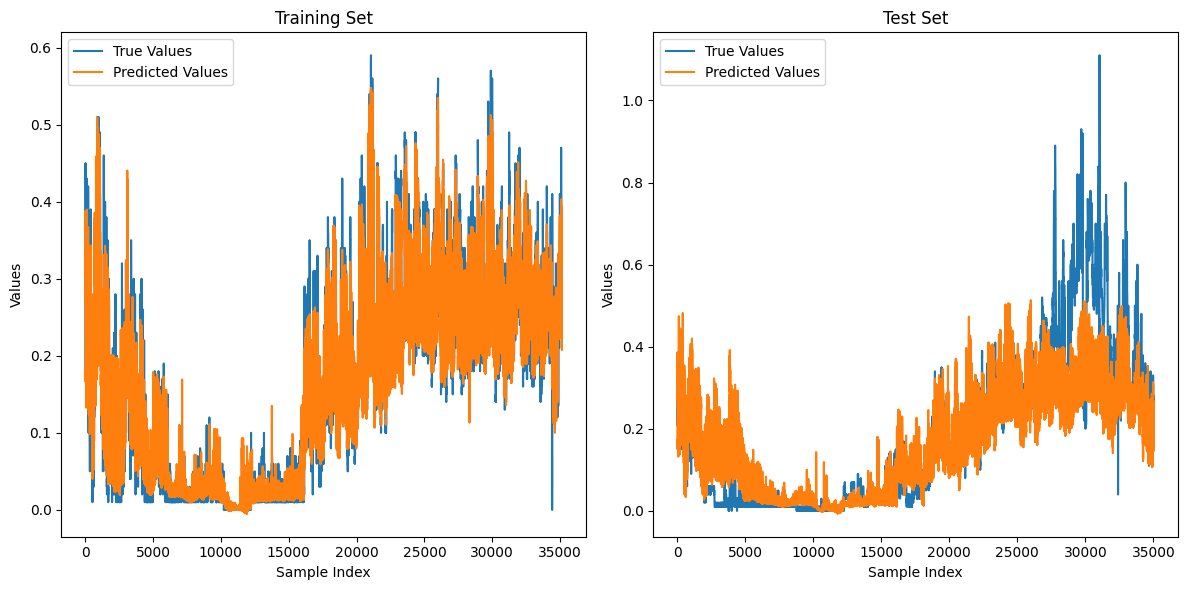

In [7]:
from matplotlib import pyplot as plt

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for the training set
ax1.plot(y_train, label='True Values')
ax1.plot(y_train_preds, label='Predicted Values')
ax1.set_title('Training Set')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Values')
ax1.legend()

# Plot for the test set
ax2.plot(y_test, label='True Values')
ax2.plot(y_test_preds, label='Predicted Values')
ax2.set_title('Test Set')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Values')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

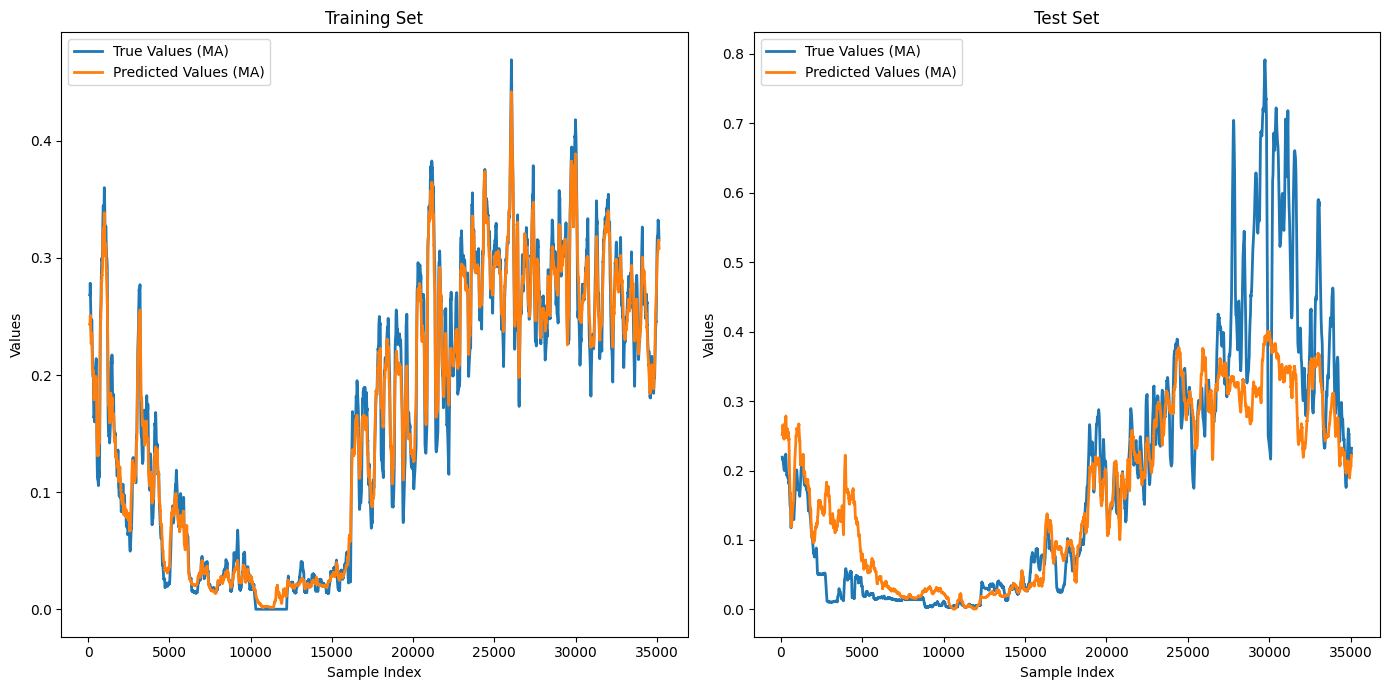

In [8]:
y_train_ma = pd.Series(y_train).rolling(window=100).mean()
y_train_preds_ma = pd.Series(y_train_preds).rolling(window=100).mean()
y_test_ma = pd.Series(y_test).rolling(window=100).mean()
y_test_preds_ma = pd.Series(y_test_preds).rolling(window=100).mean()


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot for the training set
ax1.plot(y_train_ma, label='True Values (MA)', linewidth=2)
ax1.plot(y_train_preds_ma, label='Predicted Values (MA)', linewidth=2)
ax1.set_title('Training Set')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Values')
ax1.legend()

# Plot for the test set
ax2.plot(y_test_ma, label='True Values (MA)', linewidth=2)
ax2.plot(y_test_preds_ma, label='Predicted Values (MA)', linewidth=2)
ax2.set_title('Test Set')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Values')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [16]:
train_df = df_train[['temp_outside', 'consumption']].copy()
train_df['y_pred'] = y_train_preds

reference_df = df_test[['temp_outside', 'consumption']].copy()
reference_df['y_pred'] = y_test_preds

monitored_df = df_prod[['temp_outside', 'consumption']].copy()
monitored_df['y_pred'] = reg.predict(df_prod[model_features])

In [10]:
features = ['temp_outside']
y_pred = 'y_pred'
target = 'consumption'

# Red Flag 1: using training data as reference data

## fit on training data

In [46]:
performance_calc = nml.PerformanceCalculator(
    y_pred=y_pred,
    y_true=target,
    metrics=['rmse'],
    chunk_size=2000,
    problem_type='regression',
)

performance_calc.fit(train_df)
realized_results = performance_calc.calculate(monitored_df)
fig = realized_results.plot()
fig.show()

fig.write_image('train_performance_results.svg')

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in ve

## fit on test data

In [47]:
performance_calc = nml.PerformanceCalculator(
    y_pred=y_pred,
    y_true=target,
    metrics=['rmse'],
    chunk_size=2000,
    problem_type='regression',
)

performance_calc.fit(reference_df)
realized_results = performance_calc.calculate(monitored_df)
fig = realized_results.plot()
fig.show()
fig.write_image('test_performance_results.svg')

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in ve

# Red Flag 2: not providing the chunk size of their experiments

## Using small chunk size

In [26]:
univariate_drift_calc = nml.UnivariateDriftCalculator(
    column_names=features + [y_pred],
    treat_as_categorical=y_pred,
    continuous_methods=['kolmogorov_smirnov'],
    categorical_methods=['jensen_shannon'],
    chunk_size=100
)

univariate_drift_calc.fit(reference_df)

univariate_drift_results = univariate_drift_calc.calculate(monitored_df)
univariate_drift_results.plot()

In [40]:
performance_calc = nml.PerformanceCalculator(
    y_pred=y_pred,
    y_true=target,
    metrics=['rmse'],
    chunk_size=100,
    problem_type='regression',
)

performance_calc.fit(reference_df)
realized_results = performance_calc.calculate(monitored_df)
realized_results.plot()

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in ve

## Using a big chunk size

In [27]:
univariate_drift_calc = nml.UnivariateDriftCalculator(
    column_names=features + [y_pred],
    treat_as_categorical=y_pred,
    continuous_methods=['kolmogorov_smirnov'],
    categorical_methods=['jensen_shannon'],
    chunk_size=2000
)

univariate_drift_calc.fit(reference_df)

univariate_drift_results = univariate_drift_calc.calculate(monitored_df)
univariate_drift_results.plot()

In [39]:
performance_calc = nml.PerformanceCalculator(
    y_pred=y_pred,
    y_true=target,
    metrics=['rmse'],
    chunk_size=2000,
    problem_type='regression',
)

performance_calc.fit(reference_df)
realized_results = performance_calc.calculate(monitored_df)
realized_results.plot()

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in ve

# Red flag 3: comparing only univariate drift methods

Doesn't apply for this model since it has only one feature (temp_outside)

# Red flag 4: focusing only on data drift and not on model performance

## Performance estimation

### DLE

In [51]:
dle = nml.DLE(
    feature_column_names=features,
    y_pred=y_pred,
    y_true=target,
    metrics=['rmse'],
    chunk_size=2000
)

dle.fit(reference_df)
dle_results = dle.estimate(monitored_df)
fig = dle_results.plot()
fig.show()
fig.write_image('dle_results.svg')

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in ve

## Realized vs. Esimated performance

In [48]:
performance_calc = nml.PerformanceCalculator(
    y_pred=y_pred,
    y_true=target,
    metrics=['mae', 'rmse'],
    chunk_size=2000,
    problem_type='regression',
).fit(reference_df)

realized_results = performance_calc.calculate(monitored_df)
fig = dle_results.filter(metrics='rmse').compare(realized_results.filter(metrics='rmse')).plot()
fig.show()
fig.write_image('realized_rmse_vs_estimated_rmse.svg')

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/Users/santiago/miniconda3/envs/nannymlPremium/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in ve

In [50]:
fig = realized_results.filter(metrics='rmse').plot()
fig.show()
fig.write_image('rmse_realized_performance.svg')